In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import plotly.express as px

In [41]:
# Load data
from google.colab import files
uploaded = files.upload()

Saving churner.csv to churner (1).csv


In [42]:
df = pd.read_csv("churner.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
5090,6502-HCJTI,Male,1,Yes,No,7,Yes,Yes,Fiber optic,Yes,...,No,No,No,Yes,Month-to-month,Yes,Credit card (automatic),94.70,673.1,Yes
2226,3298-QEICA,Female,0,Yes,Yes,23,No,No phone service,DSL,Yes,...,No,Yes,No,No,Two year,No,Mailed check,34.60,813.45,No
4490,0442-ZXKVS,Female,1,Yes,No,54,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Bank transfer (automatic),115.60,6431.05,No
5992,0687-ZVTHB,Male,0,Yes,Yes,65,Yes,Yes,DSL,Yes,...,Yes,No,No,Yes,One year,No,Credit card (automatic),72.45,4653.85,Yes
4800,9300-AGZNL,Male,1,No,No,1,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,94.00,94,Yes


In [43]:
df.drop(['customerID'], axis=1, inplace=True)
df.dtypes

,0
gender,object
SeniorCitizen,int64
Partner,object
Dependents,object
tenure,int64
PhoneService,object
MultipleLines,object
InternetService,object
OnlineSecurity,object
OnlineBackup,object


In [44]:
pd.to_numeric(df.TotalCharges)

ValueError: Unable to parse string " " at position 488

In [45]:
df.iloc[488]

,488
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,Yes
tenure,0
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,Yes
OnlineBackup,No


In [46]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.iloc[488]

,488
gender,Female
SeniorCitizen,0
Partner,Yes
Dependents,Yes
tenure,0
PhoneService,No
MultipleLines,No phone service
InternetService,DSL
OnlineSecurity,Yes
OnlineBackup,No


In [47]:
df.dropna(inplace=True)

In [48]:
pd.to_numeric(df.TotalCharges)

,TotalCharges
0,29.85
1,1889.50
2,108.15
3,1840.75
4,151.65
...,...
7038,1990.50
7039,7362.90
7040,346.45
7041,306.60


In [49]:
def clean_column_values(df):
    # Map for converting categorical text values to integers
    replace_map = {
        'No': 0, 'Yes': 1,
        'No phone service': 0,  # Treating 'No phone service' as 'No'
        'No internet service': 0,  # Treating 'No internet service' as 'No'
        'Female': 1, 'Male': 0  # Gender coding
    }

    # List of columns to convert from categorical text to integer
    columns_to_clean = [
        'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
        'DeviceProtection', 'TechSupport', 'StreamingTV',
        'StreamingMovies', 'PhoneService', 'Partner', 'Dependents', 'gender',
        'PaperlessBilling', 'Churn'
    ]

    # Apply mapping and convert data types
    for column in columns_to_clean:
        if column in df.columns:  # Check if the column exists in the DataFrame
            if df[column].dtype == 'object':  # Only apply to object type columns
                df[column].replace(replace_map, inplace=True)
            df[column] = df[column].astype(int)  # Safely convert to integer

# Usage
clean_column_values(df)  # Assuming df is your DataFrame



In [50]:
clean_column_values(df)  # Apply the function to clean the data


In [51]:
def print_unique_col_values(df):
    for column in df:
        print(f'{column} : {df[column].unique()}')

print_unique_col_values(df)

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService : [0 1]
MultipleLines : [0 1]
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
TechSupport : [0 1]
StreamingTV : [0 1]
StreamingMovies : [0 1]
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : [1 0]
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : [0 1]


In [52]:
# Generate dummy variables for specified categories
df1 = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=False)

# Identify dummy columns (newly created)
dummy_columns = [col for col in df1.columns if 'InternetService_' in col or 'Contract_' in col or 'PaymentMethod_' in col]

# Convert only dummy columns to integers
df1[dummy_columns] = df1[dummy_columns].astype(int)
df1.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [53]:
print_unique_col_values(df1)

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
TechSupport : [0 1]
StreamingTV : [0 1]
StreamingMovies : [0 1]
PaperlessBilling : [1 0]
MonthlyCharges : [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges : [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn : [0 1]
InternetService_DSL : [1 0]
InternetService_Fiber optic : [0 1]
InternetService_No : [0 1]
Contract_Month-to-month : [1 0]
Contract_One year : [0 1]
Contract_Two year : [0 1]
PaymentMethod_Bank transfer (automatic) : [0 1]
PaymentMethod_Credit card (automatic) : [0 1]
PaymentMethod_Electronic check : [1 0]
PaymentMethod_Mailed check : [0 1]


In [54]:
df1.dtypes

,0
gender,int64
SeniorCitizen,int64
Partner,int64
Dependents,int64
tenure,int64
PhoneService,int64
MultipleLines,int64
OnlineSecurity,int64
OnlineBackup,int64
DeviceProtection,int64


In [55]:
df1.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3112,0,0,1,0,72,1,1,1,1,0,...,0,1,0,0,0,1,1,0,0,0
4727,0,0,1,0,60,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
6619,1,0,0,0,9,1,0,0,0,0,...,0,0,1,1,0,0,1,0,0,0
758,1,0,0,1,15,1,0,0,1,0,...,0,1,0,1,0,0,1,0,0,0
5648,1,1,1,1,28,0,0,0,1,0,...,1,0,0,0,1,0,0,0,1,0


In [56]:
cols_to_scale = ['tenure','MonthlyCharges','TotalCharges']

scaler = MinMaxScaler()

df1[cols_to_scale] = scaler.fit_transform(df1[cols_to_scale])


In [57]:
for col in df1:
  print (f'{col} : {df1[col].unique()}')

gender : [1 0]
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
tenure : [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService : [0 1]
MultipleLines : [0 1]
OnlineSecurity : [0 1]
OnlineBackup : [1 0]
DeviceProtection : [0 1]
Tech

In [58]:
df1.sample(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
3049,1,0,0,0,0.028169,1,0,0,0,0,...,0,0,1,1,0,0,0,0,1,0
4785,0,0,0,0,0.239437,1,1,0,1,0,...,0,1,0,1,0,0,0,0,1,0
4706,1,0,0,0,0.000000,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


In [74]:
churn_distribution = df1['Churn'].value_counts(normalize=True)
print("Churn Distribution:")
print(churn_distribution)

Churn Distribution:
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


In [136]:
X = df1.drop('Churn', axis=1)  # Features
y = df1['Churn']               # Target variable

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [138]:
smote = SMOTE(random_state=42)

# Apply SMOTE
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [142]:
print("\nClass distribution after SMOTE (as percentages):")
print(y_train_smote.value_counts(normalize=True) * 100)


Class distribution after SMOTE (as percentages):
Churn
1    50.0
0    50.0
Name: proportion, dtype: float64


In [141]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
param_grid = {
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=3, verbose=1)
grid_search.fit(X_train_smote, y_train_smote)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 150, 200],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy', verbose=1)

In [144]:
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100  # Converts to percentage

# Rounding the accuracy to the nearest whole number
rounded_accuracy = round(accuracy)

# Print the rounded accuracy
print("Accuracy:", rounded_accuracy, "%")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 75 %
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82      1549
           1       0.53      0.67      0.59       561

    accuracy                           0.75      2110
   macro avg       0.70      0.73      0.71      2110
weighted avg       0.78      0.75      0.76      2110



In [155]:
feature_importances = pd.Series(best_xgb.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(10)

fig = px.bar(x=top_features.values, y=top_features.index, orientation='h',
             labels={'x': 'Feature Importance Score', 'y': 'Features'},
             title='Top 10 Important Features')

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [146]:
important_features = [
    'OnlineSecurity', 'PaperlessBilling', 'TechSupport',
    'InternetService_DSL', 'PaymentMethod_Electronic check',
    'InternetService_No', 'tenure', 'Contract_Two year',
    'InternetService_Fiber optic', 'Contract_Month-to-month'
]

X = df1[important_features]
y = df1['Churn']

In [147]:
param_grid = {
    'max_depth': [3, 6],
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'gamma': [0, 0.2],
    'subsample': [0.6, 0.9],
    'colsample_bytree': [0.6, 0.9],
    'reg_alpha': [0, 1],
    'reg_lambda': [1, 0.2]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
grid_search = GridSearchCV(xgb_model, param_grid, scoring='accuracy', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
Best parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.6}


In [148]:
final_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    colsample_bytree=0.9,
    gamma=0.2,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    reg_alpha=1,
    reg_lambda=1,
    subsample=0.6
)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [149]:
y_pred = final_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred) * 100
rounded_accuracy = round(accuracy)

print("Final Model Accuracy:", rounded_accuracy, "%")
print("Final Model Classification Report:")
print(classification_report(y_test, y_pred))

Final Model Accuracy: 80 %
Final Model Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1549
           1       0.67      0.45      0.54       561

    accuracy                           0.80      2110
   macro avg       0.75      0.69      0.70      2110
weighted avg       0.78      0.80      0.78      2110



In [159]:
cv_scores = cross_val_score(final_model, X, y, cv=5, scoring='accuracy')

print("CV Scores:", cv_scores)
print("CV Mean:", round(cv_scores.mean() *100),"%")
print("CV Standard deviation:", cv_scores.std())

CV Scores: [0.80668088 0.79957356 0.7802276  0.8029872  0.79658606]
CV Mean: 80 %
CV Standard deviation: 0.009137301206200262


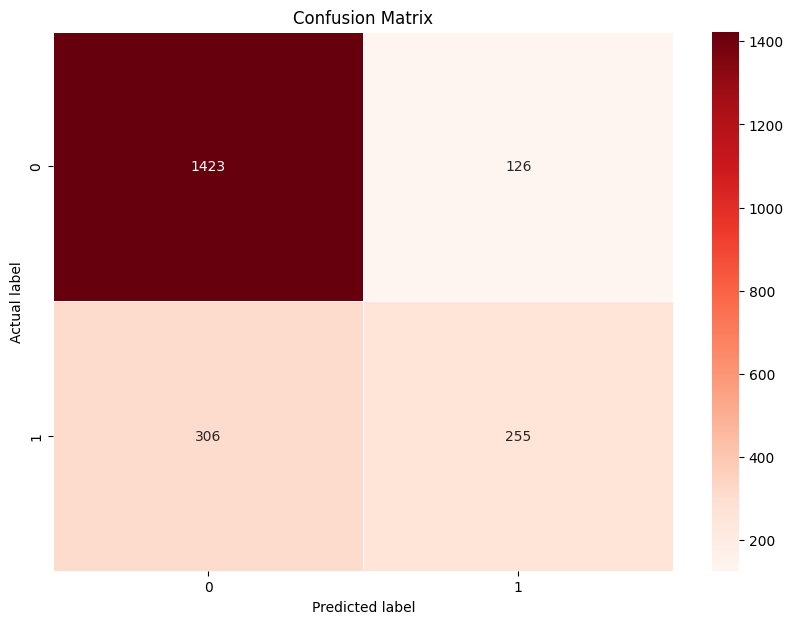

In [161]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, cmap="Reds")
plt.title('Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [160]:
false_pos_rate, true_pos_rate, _ = roc_curve(y_test, best_xgb.predict_proba(X_test)[:, 1])
auc_score = auc(false_pos_rate, true_pos_rate)

fig = px.area(
    x=false_pos_rate, y=true_pos_rate,
    title=f'ROC Curve (AUC = {auc_score:.4f})',
    labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
    width=700, height=500
)

fig.add_shape(
    type='line', line={'dash': 'dash'},
    x0=0, x1=1, y0=0, y1=1
)

fig.show()
